In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#For Chi-Square Test
from scipy.stats import chi2_contingency
from scipy.stats import chi2

#Data PreProcessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk import stem
from nltk.stem import WordNetLemmatizer
import re

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

#Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

#Model Selection and Voting Classifier
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier

from scipy import interp
from itertools import cycle

In [2]:
#Importing the dataset (Mushroom)
dataset= pd.read_csv('train.csv')
data_test= pd.read_csv('test.csv')

In [3]:
dataset.head()

,Class,Name,Description
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


In [4]:
dataset.info(memory_usage='deep')#including memory consumption

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 3 columns):
Class          560000 non-null int64
Name           560000 non-null object
Description    560000 non-null object
dtypes: int64(1), object(2)
memory usage: 268.5 MB


In [5]:
#According to the results in the previous cell, there are 3 columns present in the dataset with 560000 observations
#Class column is of int datatype and columns Name and Description are of Categorical Datatypes (TEXT)

In [6]:
dataset.isnull().values.any()

False

In [7]:
print(dataset.isnull().sum())

Class          0
Name           0
Description    0
dtype: int64


In [8]:
#Defining the train and target
X=dataset.drop(['Class'],axis=1)
y=dataset['Class']

In [9]:
print(dataset['Class'].value_counts().count())
#There are 14 distinct classes in the Target variable

14


14    40000
13    40000
12    40000
11    40000
10    40000
9     40000
8     40000
7     40000
6     40000
5     40000
4     40000
3     40000
2     40000
1     40000
Name: Class, dtype: int64


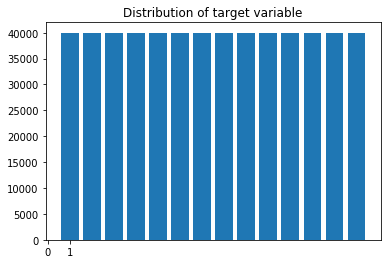

In [10]:
x=y.value_counts()
print(x)
plt.bar(x.index,x)
plt.gca().set_xticks([0,1])
plt.title('Distribution of target variable')
plt.show()

In [11]:
#The above plot shows that there is no class imbalance present in the data
#Every class is having exactly 40,000 documents pertaining to it
for i in range(len(dataset.columns)):
    print(dataset.columns[i], ' column is having ', dataset[dataset.columns[i]].value_counts().count(), ' variables')

Class  column is having  14  variables
Name  column is having  560000  variables
Description  column is having  559879  variables


In [12]:
#From the above Exploratory Data Analysis, it is found that 121 (560000-559879) companies have redundant descriptions

In [13]:
#ChiSquare Test is done to find the independent columns present in the dataset and drop them as they may pertain to noise
def ChiSquareTest(data, target):
    result1= list()
    result2= list()
    X= data.drop(target, axis= 1)
    for column in range(X.shape[1]):
        data_crosstab = pd.crosstab(X[X.columns[column]], data[target], margins = False) 
        stat, p, dof, expected = chi2_contingency(data_crosstab)
        
        # interpret test-statistic
        prob = 0.95
        critical = chi2.ppf(prob, dof)
        if not(abs(stat) >= critical):
            result1.append(X.columns[column])
            
        # interpret p-value
        alpha = 1.0 - prob
        if not(p <= alpha):
            result2.append(X.columns[column])
        
    return(result1, result2)

In [14]:
test_statistic_result, p_value_result= ChiSquareTest(dataset, 'Class')

In [15]:
print(test_statistic_result)
print(p_value_result)

['Name', 'Description']
['Name', 'Description']


In [16]:
#Surprised! The results of ChiSquare Test show that both the columns are actually independent and thus doesnot 
#affect the Class variable in any manner. But since they are text and by some domain understanding, I assume that
#the column Name can be dropped from the dataset but still column Description might be useful to us for analyzing.

In [17]:
#Dropping Name Column from the dataset
dataset= dataset.drop('Name', axis= 1)
dataset.head()

,Class,Description
0,1,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center is a hospital loc...


In [18]:
# describe Description column of type np.object 
dataset[['Description']].describe(include=np.object).transpose()

,count,unique,top,freq
Description,560000,559879,Tom Clancy's Net Force Explorers or Net Force...,15


In [19]:
#The above cell describes that the Description "Tom Clancy's Net Force Explorers or Net Force..." occurs the most
#with 15 instances

In [20]:
print(dataset['Description'].value_counts()[:96])

 Tom Clancy's Net Force Explorers or Net Force Explorers is a series of young adult novels created by Tom Clancy and Steve Pieczenik as a spin-off of the military fiction series Tom Clancy's Net Force.                                                                                                                                                                                                   15
 Steinkopf is a mountain of Hesse Germany.                                                                                                                                                                                                                                                                                                                                                                   4
 Bieber is a river of Hesse Germany.                                                                                                                                                                      

In [21]:
#We found before that there are 121 redundant entries present in the Description column of the dataset. Now there
#is an improvement in that thought. According to the above cell, it can be inferred that there are 95 Descriptions
#which occur more than once in the dataset

In [22]:
#Due to memory constraints present in the machine, I would like to sample the dataset considering only 20% of the whole

In [23]:
sample = dataset.sample(n=112000,random_state= 1234)
sample

,Class,Description
288421,8,Mount Lawson was named by Walter Wilcox and H...
344683,9,Myszki [ˈmɨʂki] is a village in the administr...
455530,12,8 was released in 2005 and is an album from S...
322847,9,Banar Kabutaran (Persian: بناركبوتران‎ also R...
539589,14,Out of the Fire (ISBN 0-8041-0104-3) is a Vie...
...,...,...
403982,11,Fritillaria imperialis (Crown imperial or Kai...
260867,7,Fountain Elms is a historic home located at U...
161143,5,Scott Moe is a Canadian politician who was el...
149396,4,George Richard Pullinger (14 March 1920 – 4 A...


In [24]:
#Pre-processing the data

In [25]:
#Changing the descriptions to lowercase
sample['Description'] = [entry.lower() for entry in sample['Description']]

In [26]:
def CleanText(text):
    text = replace.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = symbols.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    return text

In [27]:
#Erasing all the symbols and maintaining the description containing only the alpha-numeric characters
replace = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')

sample['Description'] = sample['Description'].apply(CleanText)

In [28]:
#Contractions are short forms used while writing, mostly based on the sound the particular word creates.
#Here we try to replace all the contractions used in the text using a contractions dictionary

In [29]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [30]:
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

In [31]:
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [32]:
contractions, contractions_re = _get_contractions(contraction_dict)
sample['Description']= sample['Description'].apply(replace_contractions)

In [33]:
#Lemmatizing:
#It is the process of sorting or grouping together inflected or variant forms of the same word
#Let's attempt to so Lemmatization on the description column of the sample dataset

In [34]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [35]:
sample['Description']= sample['Description'].apply(lemmatize_stemming)
sample

,Class,Description
288421,8,mount lawson was named by walter wilcox and h...
344683,9,myszki mki is a village in the administrati...
455530,12,8 was released in 2005 and is an album from s...
322847,9,banar kabutaran persian also romanized as b...
539589,14,out of the fire isbn 0804101043 is a vietna...
...,...,...
403982,11,fritillaria imperialis crown imperial or kai...
260867,7,fountain elms is a historic home located at u...
161143,5,scott moe is a canadian politician who was el...
149396,4,george richard pullinger 14 march 1920 4 au...


In [36]:
#Defining the train and target for the sample
X=sample.drop(['Class'],axis=1)
y=sample['Class']

12    8121
14    8080
2     8054
3     8050
10    8045
13    8019
7     8005
4     7996
8     7974
11    7970
6     7961
9     7932
5     7903
1     7890
Name: Class, dtype: int64


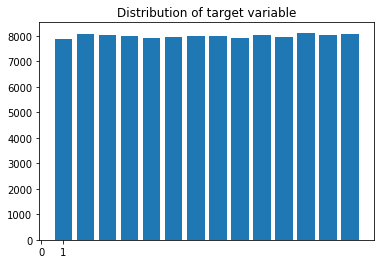

In [37]:
#Checking whether there is any class imbalance in the sample or not
x=y.value_counts()
print(x)
plt.bar(x.index,x)
plt.gca().set_xticks([0,1])
plt.title('Distribution of target variable')
plt.show()

In [38]:
#And it is found that there doesnot exist much class imbalance as most of the classes contains 8,000 documents approximately

In [39]:
description = sample['Description'].tolist()

In [40]:
#To get X train, we use TfidfVectorizer from sklearn
#The vocabulary of training is used to get X test

#The goal of using tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus 
#and are empirically less informative than features that occur in a small fraction of the training corpus

tfidf = TfidfVectorizer()
tfidf.fit_transform(description)
X = tfidf.transform(description)
Y = sample['Class'].tolist()
Xtest = tfidf.transform(data_test['Description'].tolist())
Ytest = data_test['Class'].tolist()

In [41]:
#Usage of many Baseline models were given in order to find the best model to be used
#Some of the models used are as follows:
# 1) Decision Tree Classifier
# 2) Logistic Regression
# 3) Support Vector Machines
# 4) Random Forest
# 5) Multinomial Naive Bayes
# 6) K- Nearest Neighbours
# 7) Ensemble of some of the above
# 8) XGBoost

In [42]:
def DecisionTree(X_train,y_train, X_test, y_test):
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(X_train, y_train)
    y_pre = classifier.predict(X_test)
    print("\nDecision Tree Classifier\n")
    print('\nAccuracy while using Decision Tree Classifier: ',accuracy_score(y_test,y_pre))
    print('\nConfusion Matrix while using Decision Tree Classifier is as follows: \n',confusion_matrix(y_test,y_pre), '\n')
    print('\nCohen''s Kappa while using Decision Tree Classifier: ',cohen_kappa_score(y_test,y_pre), '\n')
    print('\nThe Classification Report for Decision Tree Classifier is as follows: \n', classification_report(y_test, y_pre))
    print('\nThe ROC Plot for Decision Tree Classifier is as follows: \n')
    plot_roc(y_test, y_pre)

In [43]:
def Logistic_Regression(X_train,y_train, X_test, y_test):
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    y_pre=lr.predict(X_test)
    print('\nAccuracy while using Logistic Regression: ',accuracy_score(y_test,y_pre), '\n')
    print('\nConfusion Matrix while using Logistic Regression is as follows: \n',confusion_matrix(y_test,y_pre), '\n')
    print('\nCohen''s Kappa while using Logistic Regression: ',cohen_kappa_score(y_test,y_pre), '\n')
    print('\nThe Classification Report for Logistic Regression is as follows: \n', classification_report(y_test, y_pre))
    print('\nThe ROC Plot for Logistic Regression is as follows: \n')
    plot_roc(y_test, y_pre)

In [44]:
def SVM(X_train,y_train, X_test, y_test):
    classifier = SVC(kernel = 'linear', random_state = 0)
    classifier.fit(X_train, y_train)
    y_pre = classifier.predict(X_test)
    print('\nAccuracy while using Support Vector Machines: ',accuracy_score(y_test,y_pre))
    print('\nConfusion Matrix while using Support Vector Machines is as follows: \n',confusion_matrix(y_test,y_pre), '\n')
    print('\nCohen''s Kappa while using Support Vector Machines: ',cohen_kappa_score(y_test,y_pre), '\n')
    print('\nThe Classification Report for Support Vector Machines is as follows: \n', classification_report(y_test, y_pre))
    print('\nThe ROC Plot for Support Vector Machines is as follows: \n')
    plot_roc(y_test, y_pre)

In [45]:
def RandomForest(X_train,y_train, X_test, y_test):
    classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    classifier.fit(X_train, y_train)
    y_pre = classifier.predict(X_test)
    print('\nAccuracy while using Random Forest Classifier: ',accuracy_score(y_test,y_pre))
    print('\nConfusion Matrix while using Random Forest Classifier is as follows: \n',confusion_matrix(y_test,y_pre), '\n')
    print('\nCohen''s Kappa while using Random Forest Classifier: ',cohen_kappa_score(y_test,y_pre), '\n')
    print('\nThe Classification Report for Random Forest Classifier is as follows: \n', classification_report(y_test, y_pre))
    print('\nThe ROC Plot for Random Forest Classifier is as follows: \n')
    plot_roc(y_test, y_pre)

In [46]:
def MultinomialNaiveBayes(X_train,y_train, X_test, y_test):
    classifier = MultinomialNB()
    classifier.fit(X_train, y_train)
    y_pre = classifier.predict(X_test)
    print('\nAccuracy while using Multinomial Naive Bayes: ',accuracy_score(y_test,y_pre))
    print('\nConfusion Matrix while using Multinomial Naive Bayes is as follows: \n',confusion_matrix(y_test,y_pre), '\n')
    print('\nCohen''s Kappa while using Multinomial Naive Bayes: ',cohen_kappa_score(y_test,y_pre), '\n')
    print('\nThe Classification Report for Multinomial Naive Bayes is as follows: \n', classification_report(y_test, y_pre))
    print('\nThe ROC Plot for Multinomial Naive Bayes is as follows: \n')
    plot_roc(y_test, y_pre)

In [47]:
def KNN(X_train,y_train, X_test, y_test, k):
    classifier = KNeighborsClassifier(k)
    classifier.fit(X_train, y_train)
    y_pre = classifier.predict(X_test)
    print('\nAccuracy while using K- Nearest Neighbours: ',accuracy_score(y_test,y_pre))
    print('\nConfusion Matrix while using K- Nearest Neighbours is as follows: \n',confusion_matrix(y_test,y_pre), '\n')
    print('\nCohen''s Kappa while using K- Nearest Neighbours: ',cohen_kappa_score(y_test,y_pre), '\n')
    print('\nThe Classification Report for K- Nearest Neighbours is as follows: \n', classification_report(y_test, y_pre))
    print('\nThe ROC Plot for K- Nearest Neighbours is as follows: \n')
    plot_roc(y_test, y_pre)

In [48]:
def Voting(X, y):
    kfold = model_selection.KFold(n_splits=10, random_state= 7)
    # create the sub models
    estimators = []
    model1 = LogisticRegression()
    estimators.append(('logistic', model1))
    model2 = DecisionTreeClassifier()
    estimators.append(('cart', model2))
    model3 = SVC()
    estimators.append(('svm', model3))
    model4 = RandomForestClassifier()
    estimators.append(('RandomForest', model4))
    model5= MultinomialNB()
    estimators.append(('MultinomialNB', model5))
    # create the ensemble model
    ensemble = VotingClassifier(estimators)
    results = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
    print("Voting results are as follows: ", results)
    print(results.mean())

In [49]:
def XGBoost(X_train,y_train, X_test, y_test):
    classifier = XGBClassifier(subsample=0.20,n_estimators=100, random_state=42)
    classifier.fit(X_train, y_train)
    y_pre = classifier.predict(X_test)
    print('\nAccuracy while using XGBoost: ',accuracy_score(y_test,y_pre))
    print('\nConfusion Matrix while using XGBoost is as follows: \n',confusion_matrix(y_test,y_pre), '\n')
    print('\nCohen''s Kappa while using XGBoost: ',cohen_kappa_score(y_test,y_pre), '\n')
    print('\nThe Classification Report for XGBoost is as follows: \n', classification_report(y_test, y_pre))
    print('\nThe ROC Plot for XGBoost is as follows: \n')
    plot_roc(y_test, y_pre)

In [50]:
def plot_roc(y_test, predictions):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes= 14
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(predictions))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2
    plt.figure(figsize=(8,5))
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'blue', 'red', 'black', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.annotate('Random Guess',(.5,.48),color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


Decision Tree Classifier


Accuracy while using Decision Tree Classifier:  0.8702285714285715

Confusion Matrix while using Decision Tree Classifier is as follows: 
 [[3697  106  112   14   52  265  267  100   14   40   67   50   60  156]
 [  90 4595   35    1   26   23  133   23   14    6   11    3    9   31]
 [ 125   21 3774  240  490   61   34   13    3   15   19   58   55   92]
 [  26    9  316 4501   98   18   11    3    0    2    1    2    1   12]
 [  66   15  441   88 4213   61   37   15    6    9   12    2    4   31]
 [ 231   22   86   15   50 4234  167   41    4   24   24   16   24   62]
 [ 240  135   48    8   44  191 3977  178   62   19   26   12   10   50]
 [  71   33   19    2   12   50  209 4465   52   21   29    3    2   32]
 [   8    4    3    0    4    1   39   37 4900    0    0    1    0    3]
 [  42    2   21    7    8   36   27   33    0 4481  312    6    4   21]
 [  79   19   10    1    8   23   28   35    2  400 4353   14    4   24]
 [  51    1   58    4    6   1

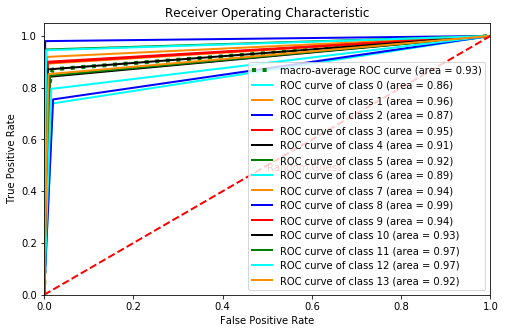

In [51]:
DecisionTree(X, Y, Xtest, Ytest)

/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Accuracy while using Logistic Regression:  0.9735571428571429 


Confusion Matrix while using Logistic Regression is as follows: 
 [[4695   43   19    7   11   67   52    6    2    5    3   16   22   52]
 [  47 4888    4    0    5    3   36    4    1    1    1    0    3    7]
 [  25   13 4716   12   61    1    7    0    0    0    0   59   28   78]
 [   3    1   50 4925   13    5    0    1    0    0    0    0    1    1]
 [   8   19   92   12 4852   11    3    1    0    0    0    0    0    2]
 [  41    0    2    1    0 4932   12    6    0    1    1    0    2    2]
 [  61   50   10    0   10   24 4785   41    9    3    0    1    1    5]
 [   3    1    0    0    3    4   20 4952   10    2    5    0    0    0]
 [   1    1    1    0    0    0   18   23 4954    1    0    0    0    1]
 [   4    0    4    7    0    5    0   10    0 4906   62    0    0    2]
 [  11    1    0    0    0    3    3    5    0   83 4893    0    0    1]
 [   8    0   28    1    0    1    1    0    0    0    0 4929   1

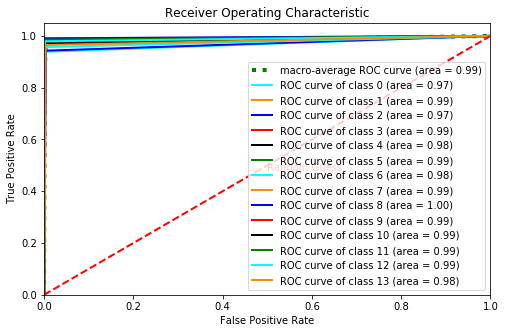

In [52]:
Logistic_Regression(X, Y, Xtest, Ytest)


Accuracy while using Support Vector Machines:  0.9794

Confusion Matrix while using Support Vector Machines is as follows: 
 [[4737   39   15    4   13   52   49    6    2    3    2   14   12   52]
 [  43 4902    2    0    4    2   36    2    2    0    0    0    2    5]
 [  25    4 4793    9   60    1    6    0    0    0    0   43   11   48]
 [   3    1   37 4943   13    1    0    0    0    0    0    0    1    1]
 [  10    7   81   10 4877    7    4    0    1    0    0    0    0    3]
 [  37    0    2    0    0 4943    7    6    0    0    1    0    1    3]
 [  65   43    5    0    4   14 4828   26   10    0    0    1    1    3]
 [   6    2    0    0    2    1   22 4954   13    0    0    0    0    0]
 [   1    1    1    0    0    0   13   15 4968    0    0    0    0    1]
 [   4    0    1    0    0    1    1    2    0 4957   33    0    0    1]
 [  10    1    1    0    0    2    4    3    0   27 4951    0    0    1]
 [   8    0   22    1    0    0    1    0    0    0    0 4946   12   10

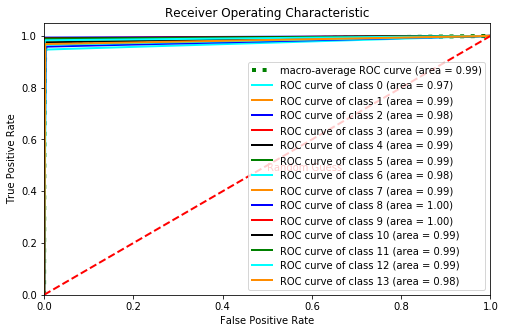

In [53]:
SVM(X, Y, Xtest, Ytest)


Accuracy while using Random Forest Classifier:  0.8851428571428571

Confusion Matrix while using Random Forest Classifier is as follows: 
 [[4144  189   71   23   29  179   88   37    3    9   13   85   29  101]
 [ 155 4616   16    5   28   18  101   23    7    1    5    4    3   18]
 [ 118   58 4053  177  202   26   14    4    1    3    3  152   46  143]
 [  15   16  245 4671   35   10    0    0    1    1    0    0    5    1]
 [  44   62  275   96 4473   21   10    6    0    0    1    0    3    9]
 [ 224   41   36   10   34 4532   35   23    0   11    7   18   11   18]
 [ 264  411   31   11   59  131 3901  129    9    5    8    8    4   29]
 [  60  101   11    6    8   41   94 4622   14   14   14    3    3    9]
 [  11   43    4    0    6    9   37   70 4816    1    1    1    0    1]
 [  38   10   33   12   14   28   14   46    3 4298  490    3    4    7]
 [  36   25   13    4    8   19   15   27    0  362 4471    5    4   11]
 [  29    3   80    3    7    8    6    5    0    2    0 

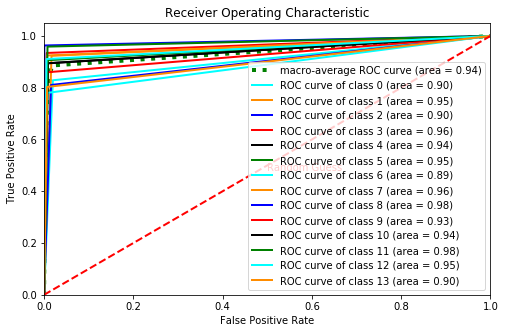

In [54]:
RandomForest(X, Y, Xtest, Ytest)


Accuracy while using Multinomial Naive Bayes:  0.951

Confusion Matrix while using Multinomial Naive Bayes is as follows: 
 [[4199   71   53   12   17  161   65    6    0    0    0  222   32  162]
 [  40 4874   10    2   14    4   37    2    2    0    1    1    0   13]
 [  17    9 4316   16  126    0   10    0    0    0    1  236   36  233]
 [   0    0   27 4941   16    6    2    0    0    0    0    2    4    2]
 [   9   11   44   16 4889   15    9    0    0    0    0    1    1    5]
 [  31    3    2    0    1 4947    9    2    0    0    0    0    2    3]
 [  45   91    8    2   17   20 4782   22    2    1    0    2    1    7]
 [   4    6    1    1    3   10   77 4884    2    2    5    2    0    3]
 [   2   47    3    0    7    2   94  100 4740    0    1    1    0    3]
 [   1    0   16   59   14    3    3    8    1 4657  225    1    1   11]
 [  16    1    2    0    0    2    9    2    0   20 4943    1    1    3]
 [   1    0   20    1    0    0    0    0    0    0    0 4954   19    5]

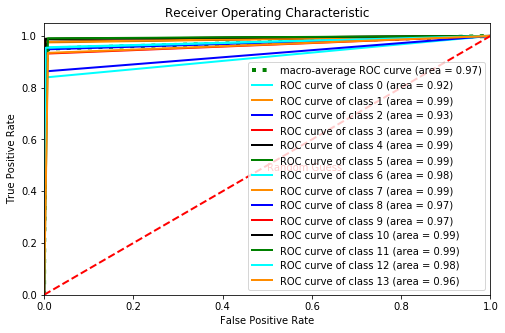

In [55]:
MultinomialNaiveBayes(X, Y, Xtest, Ytest)


Accuracy while using K- Nearest Neighbours:  0.7687571428571428

Confusion Matrix while using K- Nearest Neighbours is as follows: 
 [[3760  324  565   20   20   96   54   18    8    5    8   36   12   74]
 [ 199 4421  246    8   19    8   39   19   20    2    2    0    0   17]
 [ 263  353 3802   60   83   12   29   11    8    4    4  180   46  145]
 [  83  182  612 4088   18    4    3    4    2    0    0    2    1    1]
 [ 158  463  989   34 3280   13   16   13    6    2    0    1    5   20]
 [ 326  151  506    6    8 3953   17   12    3    8    1    5    1    3]
 [ 218  580  554    5   19   14 3564   30    4    0    1    3    4    4]
 [  78  214  473    2    4    8   18 4175   18    2    4    1    2    1]
 [  40   82  145    1    2    1   10   19 4696    0    2    0    0    2]
 [  46   49  421    2    0    4    0    7    0 4339  126    1    3    2]
 [  47   47  360    0    0    3    2   12    0   20 4504    3    0    2]
 [ 191   91  970    4    4    7   10    8    1    2    5 3676  

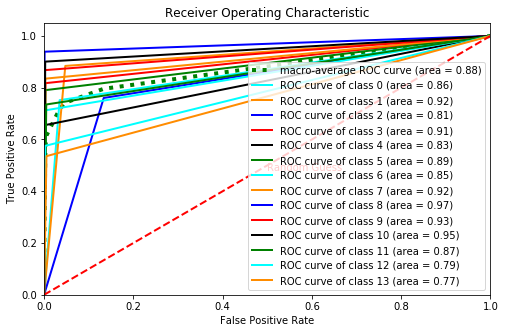

In [56]:
#Trying KNN for different values of K: 3, 5, 10, 20, 50, 75, 100
KNN(X, Y, Xtest, Ytest, 3)


Accuracy while using K- Nearest Neighbours:  0.8477428571428571

Confusion Matrix while using K- Nearest Neighbours is as follows: 
 [[3764  250  289   45   69  159  120   27   15   16   17   65   35  129]
 [ 105 4527  102   20   50   19   67   35   27    4    3    6    2   33]
 [ 176  246 3698  101  163   16   69   27   10    6    5  233   71  179]
 [  38   79  195 4593   39   10   12   12    6    0    1    7    4    4]
 [ 109  260  404  104 3952   22   43   28   16    4    0    5   10   43]
 [ 174   76  106   16   28 4483   39   27    6    8    3   15    8   11]
 [ 134  337  131   18   73   32 4162   55   10    0    6   12    6   24]
 [  47   83   74   23   13   18   90 4595   25    5    9    4    5    9]
 [  28   48   41    3    9    1   18   50 4788    2    3    1    3    5]
 [  27   24   45    7    8   19    4   27    3 4642  178    3    7    6]
 [  34   25   47    1    3    4    6   27    3  107 4734    3    1    5]
 [  74   53  361   10   14   19   25   14    4    9   12 4352  

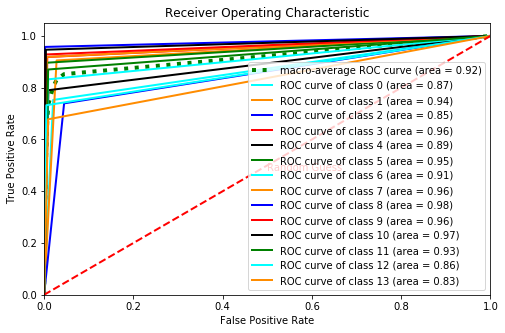

In [57]:
KNN(X, Y, Xtest, Ytest, 5)


Accuracy while using K- Nearest Neighbours:  0.8851428571428571

Confusion Matrix while using K- Nearest Neighbours is as follows: 
 [[3830  230  155   66   79  168  122   28   21   18   18   89   43  133]
 [  64 4644   46   18   60    7   53   30   33    4    6    5    4   26]
 [ 112  195 3642  133  217   22   75   33   13    5    5  260   68  220]
 [  14   39   59 4793   51    9    9   11    8    1    0    1    3    2]
 [  51  186  193  115 4309   29   28   20   18    7    2    3   14   25]
 [  80   59   37   20   26 4663   36   32    5    9    5   11   12    5]
 [  90  215   46   18   72   25 4433   56    8    1    4   12    4   16]
 [  12   49   11   21   15   10   42 4792   23    9    4    5    2    5]
 [   9   34    7    6   22    0   24   46 4838    4    4    0    1    5]
 [  16   15   19    8    9   16    6   31    4 4593  268    4    6    5]
 [  18   17   14    4    2    7    7   20    3   70 4830    3    0    5]
 [  34   30  128   15   13   14   24   13    3    4    8 4671  

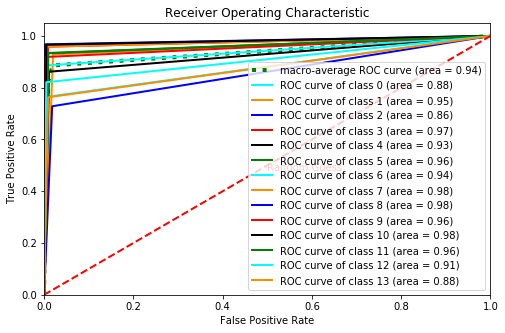

In [58]:
KNN(X, Y, Xtest, Ytest, 10)


Accuracy while using K- Nearest Neighbours:  0.9036142857142857

Confusion Matrix while using K- Nearest Neighbours is as follows: 
 [[3904  196   90   78   96  156  125   42   29   17   20   78   41  128]
 [  31 4705   18   20   67    5   58   23   29    4    5    3    6   26]
 [  77  128 3619  151  263   20   75   36   22    7    7  274   83  238]
 [   5   20   35 4850   46    6    7   14    9    5    0    0    3    0]
 [  31  121  105  103 4506   34   21   22   15    6    6    1   12   17]
 [  55   29   10   23   28 4741   30   34    7    8    6    9   13    7]
 [  65  150   15   14   68   29 4568   53   13    1    4    9    4    7]
 [   7   33    8    9   16    6   26 4856   22    6    3    2    3    3]
 [   6   20    6    5   13    0   23   50 4863    5    4    1    1    3]
 [   9   11    7    6   12   16    3   36    4 4507  372    5    5    7]
 [  17   10    4    2    5    4    8   23    2   57 4864    2    0    2]
 [  12   19   55    9   10    7   16   13    1    3    5 4812  

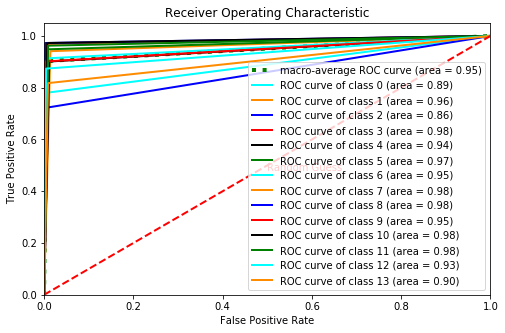

In [59]:
KNN(X, Y, Xtest, Ytest, 20)


Accuracy while using K- Nearest Neighbours:  0.9163571428571429

Confusion Matrix while using K- Nearest Neighbours is as follows: 
 [[3949  149   58   82  106  174  128   36   24   20   21   74   42  137]
 [  19 4770   10   19   59    4   51   17   22    2    8    2    5   12]
 [  52   96 3662  163  295   22   73   26   19    6    8  268   83  227]
 [   0    5   21 4894   42    9    4    7    8    3    3    0    3    1]
 [  23   90   52   93 4606   35   23   15   21    8   10    3    6   15]
 [  39   16    5   20   25 4793   33   28    8    8    4    9    4    8]
 [  39  112    3   11   61   23 4665   57   11    2    1    5    2    8]
 [   6   10    2    8   17    2   26 4894   23    6    2    2    0    2]
 [   2   13    2   10    9    0   29   63 4862    2    5    1    1    1]
 [   5    3    5    5   17   12    3   37    7 4435  456    4    7    4]
 [  10    8    1    5    4    4    5   16    4   76 4860    4    1    2]
 [   4   11   26   10   10    6   13    6    2    3    2 4882  

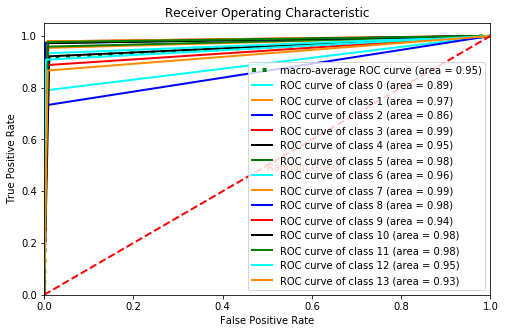

In [60]:
KNN(X, Y, Xtest, Ytest, 50)


Accuracy while using K- Nearest Neighbours:  0.9191

Confusion Matrix while using K- Nearest Neighbours is as follows: 
 [[3946  162   59   83  100  178  129   38   25   16   19   66   50  129]
 [  15 4802    7   14   45    4   48   13   33    1    3    3    3    9]
 [  44   85 3672  151  305   25   74   20   18    8    6  277   87  228]
 [   1    5   18 4899   46    6    4    3    8    3    3    0    3    1]
 [  19   85   47   85 4623   42   22   17   24    7    9    3    6   11]
 [  40   12    5   23   26 4794   38   27    5    6    4    8    2   10]
 [  35  107    5   11   56   22 4678   58   10    2    2    5    2    7]
 [   4    4    1    7   14    2   24 4909   23    6    2    2    0    2]
 [   2   17    1    9   17    0   27   60 4859    2    3    0    1    2]
 [   4    1    3    9   20   13    4   36   13 4388  497    6    2    4]
 [   9    9    3    3    5    1    5   16    7   78 4856    5    1    2]
 [   3    9   19    7    8    6   12    3    1    0    2 4905   16    9]
 [

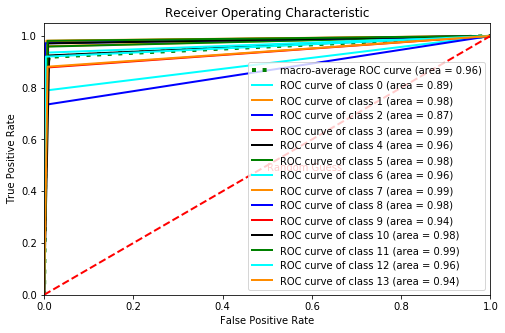

In [61]:
KNN(X, Y, Xtest, Ytest, 75)


Accuracy while using K- Nearest Neighbours:  0.9206571428571428

Confusion Matrix while using K- Nearest Neighbours is as follows: 
 [[3968  157   54   74   91  173  126   42   27   17   20   70   52  129]
 [  14 4815    7    8   36    5   47   14   35    1    5    3    3    7]
 [  42   83 3673  147  292   30   73   19   21    6    8  281   90  235]
 [   1    7   18 4902   41    7    4    2    8    3    2    0    4    1]
 [  17   81   44   84 4633   43   22   16   30    7    8    3    7    5]
 [  41   13    4   19   22 4801   33   32    5    5    4    7    3   11]
 [  33  106    4    9   46   22 4687   64   10    2    2    5    3    7]
 [   5    3    0    6   11    1   22 4915   26    5    2    2    0    2]
 [   4   14    1    8    7    1   27   65 4857    2    3    9    1    1]
 [   1    1    2    6   19   12    4   38   16 4329  560    6    4    2]
 [  10    9    3    3    5    1    5   15   12   71 4858    4    1    3]
 [   3    5   15    5    8    3    9    3    1    0    2 4921  

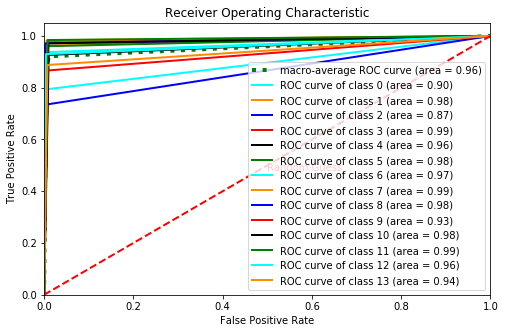

In [62]:
KNN(X, Y, Xtest, Ytest, 100)

In [63]:
Voting(X, Y)

/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", Future

/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/msc2/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", Future

Voting results are as follows:  [0.965      0.96491071 0.96571429 0.966875   0.96794643 0.963125
 0.96178571 0.96428571 0.96589286 0.96767857]
0.9653214285714284



Accuracy while using XGBoost:  0.9352571428571429

Confusion Matrix while using XGBoost is as follows: 
 [[4419   59   37   14   16  132  113   18    5   22    9   38   41   77]
 [  55 4831    9    1    8   16   54    8    3    0    1    0    4   10]
 [  55   25 4456   75  139   29    9    3    2    2    0   49   52  104]
 [   6    4  168 4748   42   19    0    3    1    6    0    0    0    3]
 [  18   27  244   39 4609   34    4    7    3    2    0    0    0   13]
 [ 189    2    9    1   13 4709   33   13    0    8    4    1    3   15]
 [ 146   77   18    0   21   97 4477   86   34   14    4    1    7   18]
 [  40    6    4    0    8   12   94 4777   29   10    7    0    0   13]
 [   5    4    2    0    5    1   11   24 4943    2    0    0    0    3]
 [  52    0   11    2    6   16    3   27    0 4656  211    0    0   16]
 [  42    5    8    0    2   16    1   23    2  465 4420    5    1   10]
 [  21    1   26    2    0    9    0    0    0    1    1 4889   31   19]
 [  15    8   16  

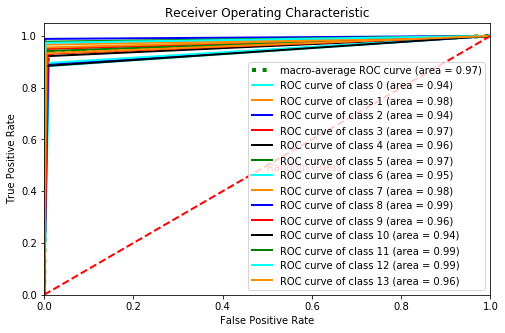

In [64]:
XGBoost(X, Y, Xtest, Ytest)

# Summary of Work done

### Exploratory Data Analysis on the Original Data and Sampling it

* The given dataset consists of 5,60,000 observations for training.
* This dataset consists of 3 columns namely Class, Name and Description and do not have any missing values present.
* There does not exist any class imbalance in the original dataset as the classes (14 in number) are equally distributed among all the observations i.e., each class contains 40,000 observations to itself.
* It was found that 121 (560000-559879) companies have redundant descriptions out of which there are 95 Descriptions which occur more than once in the dataset.
* Surprised! The results of ChiSquare Test show that both the columns are actually independent and thus does not affect the Class variable in any manner. But since they are text and by some domain understanding, I assumed that the column "Name" can be dropped from the dataset but still column "Description" might be useful to us for analyzing.
* Due to memory constraints present in the machine, I took a sample of the dataset considering only 20% of the whole (1,12,000 observations).
* Checked whether there exists any class imbalance for the sample dataset but did not find any as each class had approximately 8,000 observations to itself.

### Data Pre-processing on the Sample Dataset

* Changed the dataset to lowercase.
* Erased all the symbols and maintained the description containing only alpha-numeric characters.
* Contractions are short forms used while writing, mostly based on the sound the particular word creates. Replaced all the contractions used in the text using a contractions dictionary.
* Lemmatizing is the process of sorting or grouping together inflected or variant forms of the same word. Lemmatized the description column of the sample dataset.

### Vectorization using TfidfVectorizer

* The goal of using tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus and are empirically less informative than features that occur in a small fraction of the training corpus
* To get X train, I used TfidfVectorizer from sklearn library.
* The vocabulary of the training set is used to obtain X test.

### Usage of Baseline Models

Usage of many Baseline models were given in order to find the best model to be used and some of the models used are as follows:

 1) Decision Tree Classifier<br>
 2) Logistic Regression<br>
 3) Support Vector Machines<br>
 4) Random Forest<br>
 5) Multinomial Naive Bayes<br>
 6) K- Nearest Neighbours<br>
 7) Ensemble of some of the above<br>
 8) XGBoost<br>
 
 ## Results
 
| Model | Accuracy | Cohen's Kappa | F1-Score | 
| ---------------------- | ---------------------- | ---------------------- | ---------------------- |
| Decision Tree Classifier | 0.8702 | 0.8602 | 0.87 |
| Logistic Regression | 0.9736 | 0.9715 | 0.97 |
| Support Vector Machines | 0.9794 | 0.9778 | 0.98 |
| Random Forest | 0.8851 | 0.8763 | 0.89 |
| Multinomial Naive Bayes | 0.951 | 0.9472 | 0.95 |
| K- Nearest Neighbours | 0.9206 | 0.9146 | 0.92 |
| Voting Classifier | 0.9653 | - | - |
| XGBoost | 0.9353 | 0.9303 | 0.94 |

### Conclusion

__Except Decision Tree (0.87) and Random Forest (0.89), all the other models have crossed the 0.90 Threshold value. <br>
Best results are given by Support Vector Machines (0.98) followed by Logistic Regression (0.97) and Multinomial Naive Bayes (0.95)__
 